In [1]:
import torch
import json
import h5py
import random
import numpy as np
from matplotlib.pyplot import imshow
from PIL import Image, ImageDraw

/home/zhuohang/miniconda3/envs/rtpb/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load the following to files from DETECTED_SGG_DIR
custom_prediction = json.load(open('/home/zhuohang/checkpoints/privacy_dataset_1000/public/custom_prediction.json'))
custom_data_info = json.load(open('/home/zhuohang/checkpoints/privacy_dataset_1000/public/custom_data_info.json'))

In [3]:
def draw_single_box(pic, box, color='red', draw_info=None):
    draw = ImageDraw.Draw(pic)
    x1,y1,x2,y2 = int(box[0]), int(box[1]), int(box[2]), int(box[3])
    draw.rectangle(((x1, y1), (x2, y2)), outline=color)
    if draw_info:
        draw.rectangle(((x1, y1), (x1+50, y1+10)), fill=color)
        info = draw_info
        draw.text((x1, y1), info)
        
def print_list(name, input_list, scores=None):
    for i, item in enumerate(input_list):
        if scores == None:
            print(name + ' ' + str(i) + ': ' + str(item))
        else:
            print(name + ' ' + str(i) + ': ' + str(item) + '; score: ' + str(scores[i]))
    
def draw_image(img_path, boxes, box_labels, rel_labels, box_scores=None, rel_scores=None):
    size = get_size(Image.open(img_path).size)
    pic = Image.open(img_path).resize(size)
    num_obj = len(boxes)
    for i in range(num_obj):
        info = str(i) + '_' + box_labels[i]
        draw_single_box(pic, boxes[i], draw_info=info)
    display(pic)
    print('*' * 50)
    print_list('box_labels', box_labels, box_scores)
    print('*' * 50)
    print_list('rel_labels', rel_labels, rel_scores)
    
    return None

def get_size(image_size):
    min_size = 600
    max_size = 1000
    w, h = image_size
    size = min_size
    if max_size is not None:
        min_original_size = float(min((w, h)))
        max_original_size = float(max((w, h)))
        if max_original_size / min_original_size * size > max_size:
            size = int(round(max_size * min_original_size / max_original_size))
    if (w <= h and w == size) or (h <= w and h == size):
        return (w, h)
    if w < h:
        ow = size
        oh = int(size * h / w)
    else:
        oh = size
        ow = int(size * w / h)
    return (ow, oh)

In [4]:
# parameters
image_idx = 1
box_topk = 30 # select top k bounding boxes
rel_topk = 20 # select top k relationships
ind_to_classes = custom_data_info['ind_to_classes']
ind_to_predicates = custom_data_info['ind_to_predicates']
print(custom_data_info['idx_to_files'])

['/home/zhuohang/Documents/code/dataset/dataset/privacy_dataset_1000/public/img/798.jpg', '/home/zhuohang/Documents/code/dataset/dataset/privacy_dataset_1000/public/img/181.jpg', '/home/zhuohang/Documents/code/dataset/dataset/privacy_dataset_1000/public/img/101.jpg', '/home/zhuohang/Documents/code/dataset/dataset/privacy_dataset_1000/public/img/272.jpg', '/home/zhuohang/Documents/code/dataset/dataset/privacy_dataset_1000/public/img/464.jpg', '/home/zhuohang/Documents/code/dataset/dataset/privacy_dataset_1000/public/img/367.jpg', '/home/zhuohang/Documents/code/dataset/dataset/privacy_dataset_1000/public/img/530.jpg', '/home/zhuohang/Documents/code/dataset/dataset/privacy_dataset_1000/public/img/686.jpg', '/home/zhuohang/Documents/code/dataset/dataset/privacy_dataset_1000/public/img/795.jpg', '/home/zhuohang/Documents/code/dataset/dataset/privacy_dataset_1000/public/img/635.jpg', '/home/zhuohang/Documents/code/dataset/dataset/privacy_dataset_1000/public/img/168.jpg', '/home/zhuohang/Docu

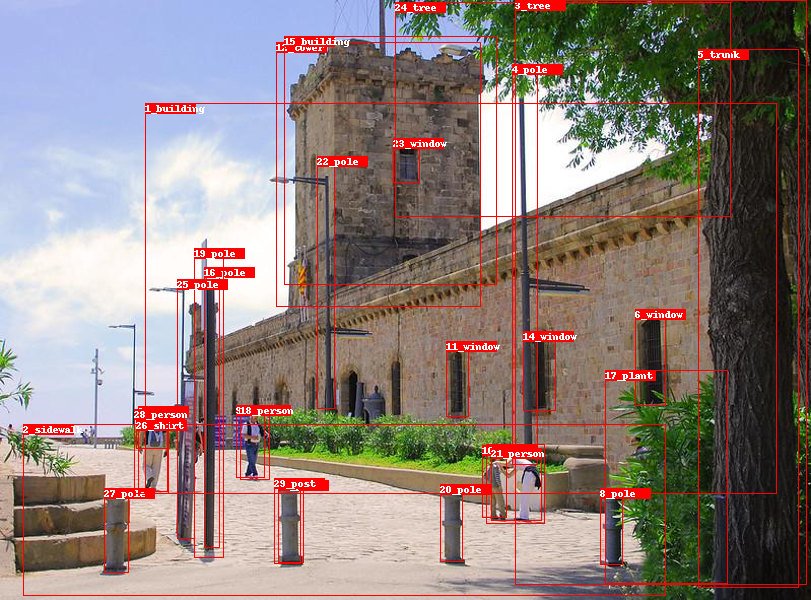

**************************************************
box_labels 0: man; score: 0.7171000242233276
box_labels 1: building; score: 0.48618805408477783
box_labels 2: sidewalk; score: 0.4647361934185028
box_labels 3: tree; score: 0.45517927408218384
box_labels 4: pole; score: 0.43069541454315186
box_labels 5: trunk; score: 0.3457913100719452
box_labels 6: window; score: 0.330798864364624
box_labels 7: woman; score: 0.31343337893486023
box_labels 8: pole; score: 0.2903682589530945
box_labels 9: woman; score: 0.28418272733688354
box_labels 10: woman; score: 0.2518535554409027
box_labels 11: window; score: 0.237772136926651
box_labels 12: tower; score: 0.219130739569664
box_labels 13: pole; score: 0.21829555928707123
box_labels 14: window; score: 0.2064172923564911
box_labels 15: building; score: 0.18827427923679352
box_labels 16: pole; score: 0.17893914878368378
box_labels 17: plant; score: 0.1735607534646988
box_labels 18: person; score: 0.1477011889219284
box_labels 19: pole; score: 0.147317

In [5]:

image_path = custom_data_info['idx_to_files'][image_idx]
boxes = custom_prediction[str(image_idx)]['bbox'][:box_topk]
box_labels = custom_prediction[str(image_idx)]['bbox_labels'][:box_topk]
box_scores = custom_prediction[str(image_idx)]['bbox_scores'][:box_topk]
all_rel_labels = custom_prediction[str(image_idx)]['bbox_labels']
all_rel_scores = custom_prediction[str(image_idx)]['rel_scores']
all_rel_pairs = custom_prediction[str(image_idx)]['rel_pairs']

for i in range(len(box_labels)):
    box_labels[i] = ind_to_classes[box_labels[i]]

rel_labels = []
rel_scores = []
for i in range(len(all_rel_pairs)):
    if all_rel_pairs[i][0] < box_topk and all_rel_pairs[i][1] < box_topk:
        rel_scores.append(all_rel_scores[i])
        label = str(all_rel_pairs[i][0]) + '_' + box_labels[all_rel_pairs[i][0]] + ' => ' + ind_to_predicates[all_rel_labels[i]] + ' => ' + str(all_rel_pairs[i][1]) + '_' + box_labels[all_rel_pairs[i][1]]
        rel_labels.append(label)

rel_labels = rel_labels[:rel_topk]
rel_scores = rel_scores[:rel_topk]

draw_image(image_path, boxes, box_labels, rel_labels, box_scores=box_scores, rel_scores=rel_scores)
